In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
from collections import defaultdict

import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import transformers
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

## Prep

In [5]:
model_name = "facebook/wav2vec2-base"
dataset_path = "data/timit_phoneme"

In [6]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
model = transformers.Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enabl

In [7]:
dataset = datasets.load_from_disk(dataset_path)

## Run evaluation

In [9]:
eval_dataset = dataset["test"].select(np.random.choice(len(dataset["test"]), 1000))

In [10]:
grouped_hidden_states = defaultdict(list)

In [11]:
def add_hidden_state(item):
    compression_ratio = (model._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()

    with torch.no_grad():
        hidden_states = model(torch.tensor(item["input_values"]).unsqueeze(0), output_hidden_states=True).hidden_states
    hidden_states = torch.stack(hidden_states)
    assert hidden_states.shape[1] == 1
    hidden_states = hidden_states[:, 0, :, :]

    i = 0
    phone_starts, phone_stops, phones = item["phonetic_detail"]["start"], item["phonetic_detail"]["stop"], item["phonetic_detail"]["utterance"]
    while i < len(phone_starts):
        phone_start, phone_stop, phone = phone_starts[i], phone_stops[i], phones[i]

        if phone not in ["tcl", "dcl", "dx", "t", "d"]:
            i += 1
            continue

        increment = 1
        if phone in ["tcl", "dcl"] and i + 1 < len(phone_starts) and phones[i + 1] in ["t", "d"]:
            # Include the release as part of this extraction too
            increment = 2
            phone_stop = phone_stops[i + 1]

        # Find the hidden state corresponding to the phone
        phone_start_idx = int(phone_start * compression_ratio)
        phone_stop_idx = int(phone_stop * compression_ratio)
        if phone_stop_idx > phone_start_idx:
            phone_hidden_states = hidden_states[:, phone_start_idx:phone_stop_idx]
        
            record_phone = phone[0] if phone in ["tcl", "dcl"] else phone
            grouped_hidden_states[record_phone].append(phone_hidden_states)

        i += increment
eval_dataset.map(add_hidden_state, batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets'],
    num_rows: 1000
})

In [12]:
grouped_hidden_states_pooled = {
    phone: torch.stack([states.nanmean(dim=1) for states in instances])
    for phone, instances in tqdm(grouped_hidden_states.items())
}

  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
all_phones = sorted(grouped_hidden_states.keys())
all_hidden_states = torch.concat([grouped_hidden_states_pooled[p] for p in all_phones])
all_labels = torch.concat([i * torch.ones(grouped_hidden_states_pooled[p].shape[0]) for i, p in enumerate(all_phones)])

In [14]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.auto import tqdm, trange

In [17]:
all_hidden_pca_models = [PCA(n_components=2).fit(all_hidden_states[:, i, :])
                         for i in range(all_hidden_states.shape[1])]
all_hidden_pca = [all_hidden_pca_models[i].transform(all_hidden_states[:, i, :])
                  for i in range(all_hidden_states.shape[1])]

In [18]:
list(enumerate([pca.explained_variance_ratio_ for pca in all_hidden_pca_models]))

[(0, array([0.09480491, 0.06978365])),
 (1, array([0.08803815, 0.0681243 ])),
 (2, array([0.09297496, 0.06979123])),
 (3, array([0.09244072, 0.07182379])),
 (4, array([0.09081384, 0.06955655])),
 (5, array([0.08722582, 0.06327733])),
 (6, array([0.08055518, 0.06252244])),
 (7, array([0.08058778, 0.06430259])),
 (8, array([0.09336747, 0.07299022])),
 (9, array([0.10786111, 0.0823082 ])),
 (10, array([0.11879911, 0.09185502])),
 (11, array([0.30889433, 0.12148941])),
 (12, array([0.30122049, 0.12285144]))]

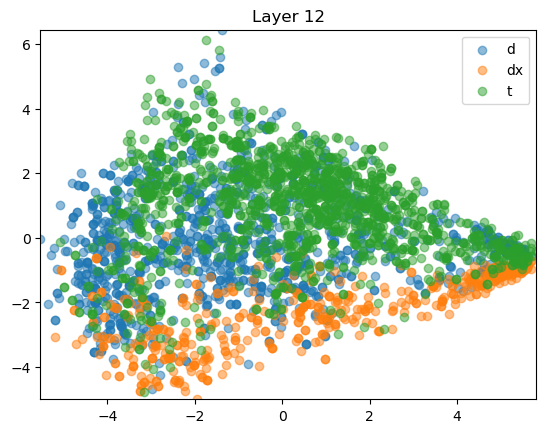

In [19]:
plot_layers = list(range(all_hidden_states.shape[1]))

f, ax = plt.subplots()
scatters = [ax.scatter(all_hidden_pca[0][all_labels == j, 0], all_hidden_pca[0][all_labels == j, 1], alpha=0.5, label=phone)
            for j, phone in enumerate(all_phones)]
ax.legend()
hidden_pca_mins = np.array([all_hidden_pca[i].min(axis=0) for i in range(len(all_hidden_pca))]).min(axis=0)
hidden_pca_maxs = np.array([all_hidden_pca[i].max(axis=0) for i in range(len(all_hidden_pca))]).max(axis=0)
ax.set_xlim(hidden_pca_mins[0], hidden_pca_maxs[0])
ax.set_ylim(hidden_pca_mins[1], hidden_pca_maxs[1])

def update(frame):
    for j, scatter in enumerate(scatters):
        scatter.set_offsets(all_hidden_pca[frame][all_labels == j])
    ax.set_title(f"Layer {frame}")

    return tuple(scatters)

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(f, update, frames=plot_layers, interval=500)
anim.save("taps.gif")
plt.show()

# f, axs = plt.subplots(len(plot_layers), 1, figsize=(10, 10 * len(plot_layers)))
# for i, (layer, ax) in enumerate(zip(plot_layers, axs.ravel())):
#     for j, phone in enumerate(all_phones):
#         plot_data = all_hidden_pca[layer][all_labels == j]
#         ax.scatter(plot_data[:, 0], plot_data[:, 1], label=phone, alpha=0.5)
#     ax.legend()
#     ax.set_title(f"Layer {layer}")

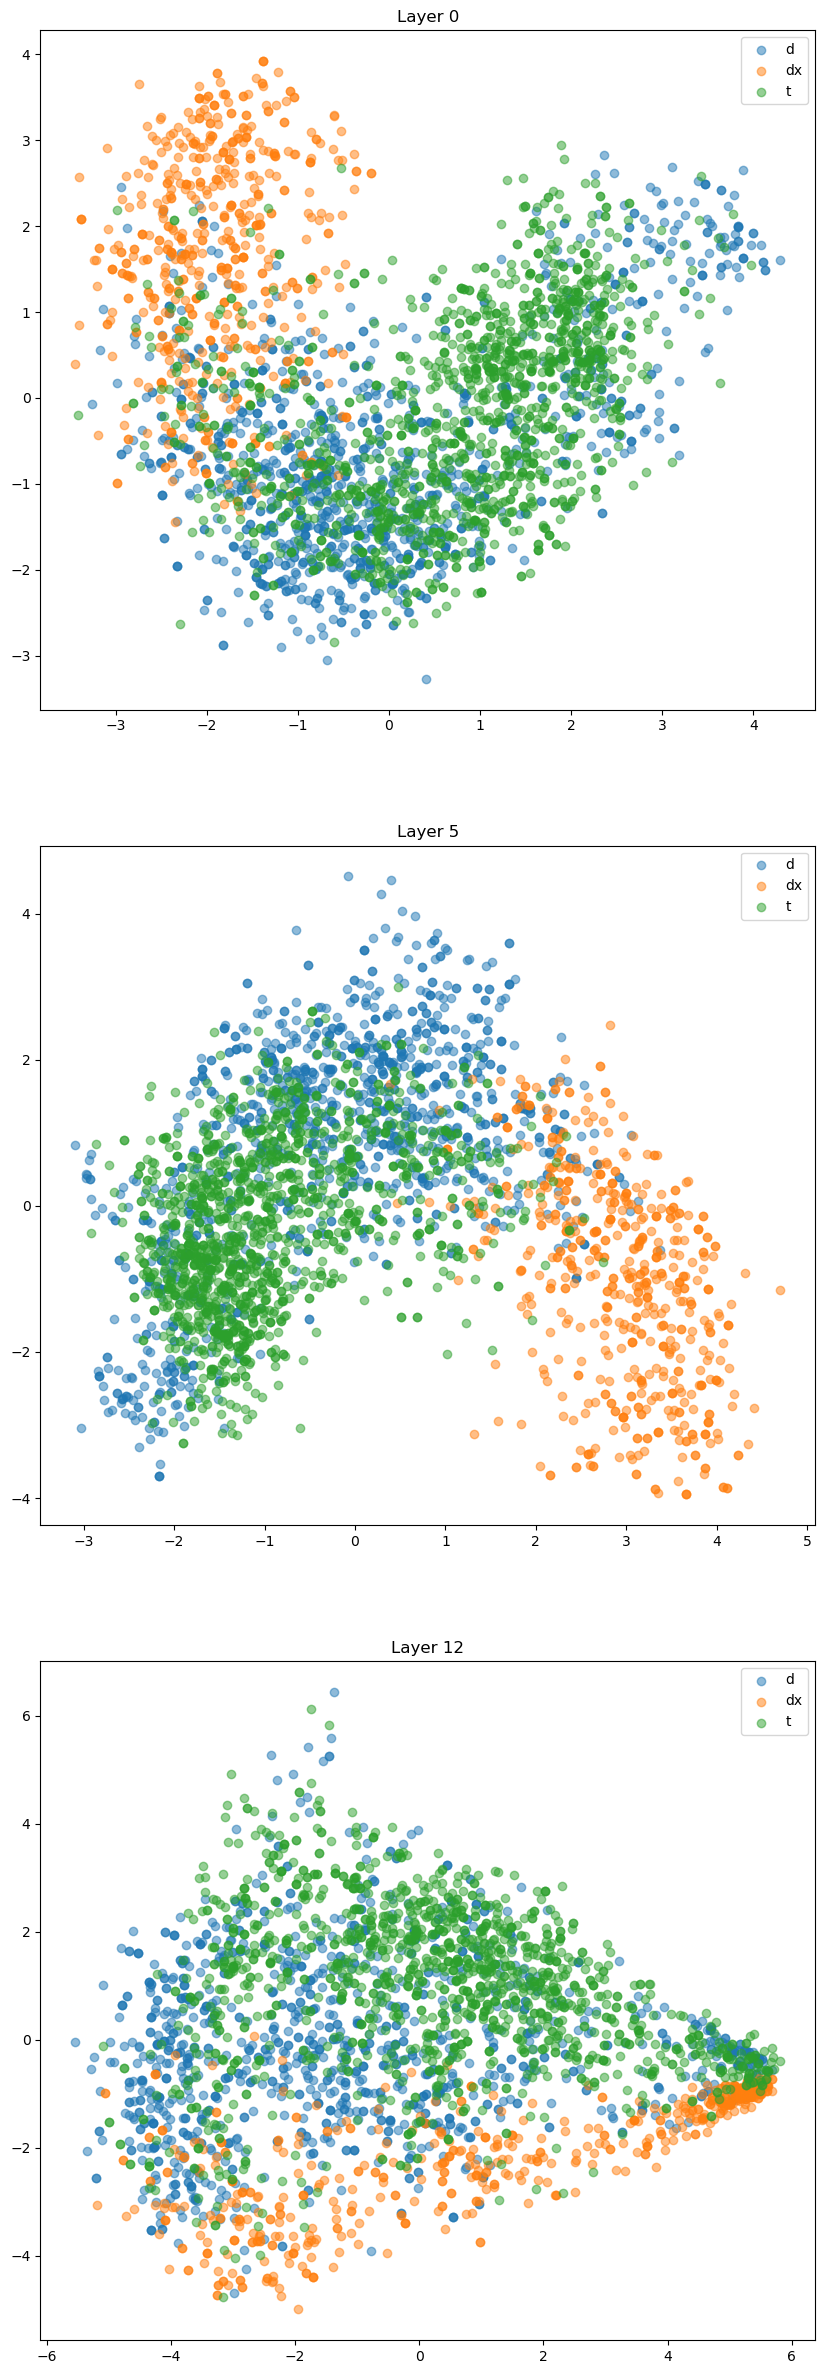

In [22]:
plot_layers = [0, 5, 12]

f, axs = plt.subplots(len(plot_layers), 1, figsize=(10, 10 * len(plot_layers)))
for i, (layer, ax) in enumerate(zip(plot_layers, axs.ravel())):
    for j, phone in enumerate(all_phones):
        plot_data = all_hidden_pca[layer][all_labels == j]
        ax.scatter(plot_data[:, 0], plot_data[:, 1], label=phone, alpha=0.5)
    ax.legend()
    ax.set_title(f"Layer {layer}")

In [21]:
# Prepare target labels
def prepare_target_labels(item, idx, padding_time=0.5):
    annot_item = annot_data[idx]

    phn_feat_names = [x[0] for x in annot_item["phnfeatNames"]]

    for idx, phn_feat_name in enumerate(phn_feat_names):
        phn_feat = annot_item["phnfeat"][idx]

        # Remove padding
        padding_samples = int(padding_time * annot_item["dataf"])
        phn_feat = phn_feat[padding_samples:-padding_samples]

        # Resample to match hidden state
        duration = len(item["input_values"]) / 16000
        num_samples = len(item["hidden_state_0"])
        phn_feat = np.interp(np.linspace(0, duration, num_samples),
                             np.arange(phn_feat.shape[0]) / annot_item["dataf"],
                             phn_feat)
        assert len(item["hidden_state_0"]) == phn_feat.shape[0]

        item[f"phn_feat_{phn_feat_name}"] = phn_feat

    return item

eval_dataset = eval_dataset.map(prepare_target_labels, with_indices=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

NameError: name 'annot_data' is not defined

In [ ]:
classifiers = {}
classifier_scores = {}

In [ ]:
eval_layers = list(range(13))
eval_features = [x[0] for x in annot_data[0]["phnfeatNames"]]
n_components = 32

import itertools
import pickle
for eval_layer, eval_feature in tqdm(list(itertools.product(eval_layers, eval_features))):
    if (eval_layer, eval_feature) in classifiers:
        continue
    X = np.concatenate([np.array(state) for state in eval_dataset[f"hidden_state_{eval_layer}"]])
    y = np.concatenate([np.array(phn_feat) for phn_feat in eval_dataset[f"phn_feat_{eval_feature}"]])
    if y.sum() == 0:
        print("No valid labels for", eval_layer, eval_feature)
        continue
    assert X.shape[0] == y.shape[0]

    # Convert to binary features
    y = (y > 0).astype(int)
    X_pca = PCA(n_components=n_components).fit_transform((X - X.mean(axis=0)) / X.std(axis=0))

    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, stratify=y, test_size=0.2, random_state=42)

    lr_model = LogisticRegressionCV(cv=StratifiedKFold(4, shuffle=True),
                                    scoring="roc_auc", class_weight="balanced",
                                    random_state=42)
    lr_model.fit(X_train, y_train)

    classifiers[eval_layer, eval_feature] = lr_model
    classifier_scores[eval_layer, eval_feature] = precision_recall_fscore_support(y_test, lr_model.predict(X_test), average="binary")

    with open("classifiers.pkl", "wb") as f:
        pickle.dump({"classifiers": classifiers, "scores": classifier_scores}, f)

  0%|          | 0/195 [00:00<?, ?it/s]

No valid labels for 0 names
No valid labels for 1 names
No valid labels for 2 names
No valid labels for 3 names
No valid labels for 4 names
No valid labels for 5 names
No valid labels for 6 names
No valid labels for 7 names
No valid labels for 8 names
No valid labels for 9 names
No valid labels for 10 names
No valid labels for 11 names
No valid labels for 12 names
